In [1]:

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import tensorflow as tf
from edward.models import Normal

plt.style.use('ggplot')


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

# read and store the separations
data_h1y = []
data_h1z = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-3) % 5 == 0:
            data_h1y.append(float(line.strip()[25:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-3) % 5 == 0:
            data_h1z.append(float(line.strip()[42:52]))
        count +=1
        
        
# convert from Bohr to angstrom
#print(np.array(data_seps)) # coordinates were recorded, not separation
# data_seps = data_seps / 0.529177

In [3]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

# read and store the separations
data_h2y = []
data_h2z = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-4) % 5 == 0:
            data_h2y.append(float(line.strip()[24:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-4) % 5 == 0:
            data_h2z.append(float(line.strip()[42:52]))
        count +=1
        
        
# convert from Bohr to angstrom
#print(np.array(data_seps)) # coordinates were recorded, not separation
# data_seps = data_seps / 0.529177

In [4]:
H2O_pos = '/Users/yatin/Documents/water/structures.xyz'

# read and store the separations
data_oy = []
data_oz = []
count = 1


with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-5) % 5 == 0:
            data_oy.append(float(line.strip()[24:35]))
        count +=1
        
        
with open(H2O_pos, 'r') as outf:
    for line in outf:
        if (count-5) % 5 == 0:
            data_oz.append(float(line.strip()[42:52]))
        count +=1
        
        
# convert from Bohr to angstrom
#print(np.array(data_seps)) # coordinates were recorded, not separation
# data_seps = data_seps / 0.529177

In [5]:
H2O_en = '/Users/yatin/Documents/water/energies.txt'

# read and store the separations
energy = []

with open(H2O_en, 'r') as outf:
    for line in outf:
        energy.append(float(line))

In [6]:
bond_1 = []
bond_2 = []
side3 = []
for loc in range(0, len(data_oy)):
    bond_1.append(math.sqrt((data_oy[loc]-data_h1y[loc])**2+(data_oz[loc]-data_h1z[loc])**2))
    bond_2.append(math.sqrt((data_oy[loc]-data_h2y[loc])**2+(data_oz[loc]-data_h2z[loc])**2))
    side3.append(math.sqrt((data_h2y[loc]-data_h1y[loc])**2+(data_h2z[loc]-data_h1z[loc])**2))

In [7]:
angle = []

for location in range(0,len(data_oy)):
    angle.append(np.arccos((bond_1[location]**2+bond_2[location]**2-side3[location]**2)/(2*bond_1[location]*bond_2[location])))


In [8]:
dataset = []

for i in range (0, len(data_oy)):
    l = []
    l.append(bond_1[i])
    l.append(bond_2[i])
    l.append(angle[i])
    dataset.append(l)


In [9]:
X = dataset


In [10]:
from sklearn.cluster import KMeans

def split(X):
    cluster = int(input())
    model = KMeans(n_clusters=cluster)
    minsos = []
    l = []
    closepts = []
    m = []
    n = []
    closest = []
    closelbl = []
    smallest = 9999
    for i in range(50):

        model.fit(X)
        y_pred = model.predict(X)
        l = []
        m = []
        n = []
        for i in {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}:
            for j in {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}[i]:
                if math.sqrt((dataset[j][0]-model.cluster_centers_[i][0])**2+(dataset[j][1]-model.cluster_centers_[i][1])**2+(dataset[j][2]-model.cluster_centers_[i][2])**2) < smallest:
                    smallest = math.sqrt((dataset[j][0]-model.cluster_centers_[i][0])**2+(dataset[j][1]-model.cluster_centers_[i][1])**2+(dataset[j][2]-model.cluster_centers_[i][2])**2)
                    closest = dataset[j]
                    closestlabel = j
            l.append(smallest)
            m.append(closest)
            n.append(closestlabel)
            smallest = 9999
        minsos.append(l)
        closepts.append(m)
        closelbl.append(n)
    
    
    smallestsos = 9999
    sos = 0
    mark = 0
    for i in range(len(minsos)):
        sos = 0
        for j in minsos[i]:
            sos = sos+j**2
        if sos < smallestsos:
            smallestsos = sos
            mark = i
    
    trainingset = closepts[mark]
    totallbl = closelbl[mark]
    

    testset = []
    testen = []
    for k in dataset:
        testset.append(k)
    for k in energy:
        testen.append(k)
    for i in range(len(dataset)):
        for j in range(len(trainingset)):
            if trainingset[j] == dataset[i]:
                testset.remove(trainingset[j])
                testen.remove(energy[i])
    test = np.array(testset)
    testenergy = np.array(testen)
    

    A = trainingset
    B = []
    for i in totallbl:
        B.append(energy[i])
    training = np.array(A)
    trainingenergy = np.array(B)
    
    return training, trainingenergy, test, testenergy, model

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor

# def run_gaussian(data, target):
#     gp = GaussianProcessRegressor(n_restarts_optimizer=20)
#     gp.fit(data, target)
    
#     return gp

# def pred_gaussian(model, tester)
#     target_pred, std = model.predict(tester, return_std=True)


In [12]:
def plot_predict(pred, correct):
    plt.figure(figsize = (10, 8))
    plt.plot(pred)
    plt.plot(correct, '--')

In [13]:
from sklearn.metrics import mean_absolute_error

def error_det(pred, correct):
    err = mean_absolute_error(correct, pred)
    return err

In [14]:
training, trainingenergy, test, testenergy, model = split(dataset)
# target_pred_t, std = run_gaussian(training, trainingenergy, training)
gp = GaussianProcessRegressor(n_restarts_optimizer=20)
gp.fit(training, trainingenergy)
target_pred_t, std_t = gp.predict(training, return_std = True)
error_det(trainingenergy, target_pred_t)

15


/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


0.0007304908415486958

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


0.45992019137757145

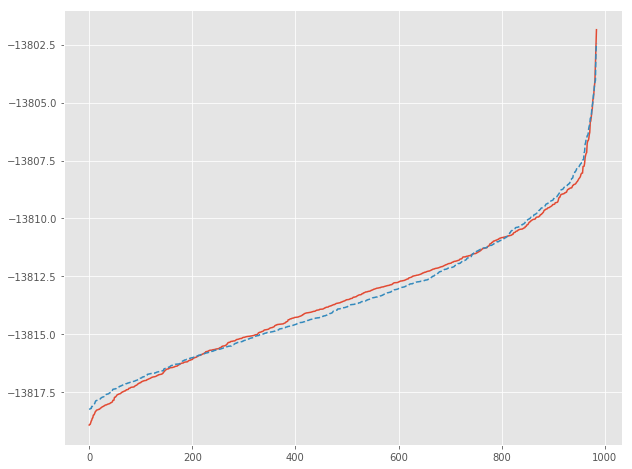

In [15]:
# training, trainingenergy, test, testenergy, model = split(dataset)
# target_pred, std = run_gaussian(training, trainingenergy, test)
target_pred, std = gp.predict(test, return_std = True)
boi = sorted(target_pred)
bongo = sorted(testenergy)
plot_predict(boi, bongo)
error_det(testenergy, target_pred)

15
15


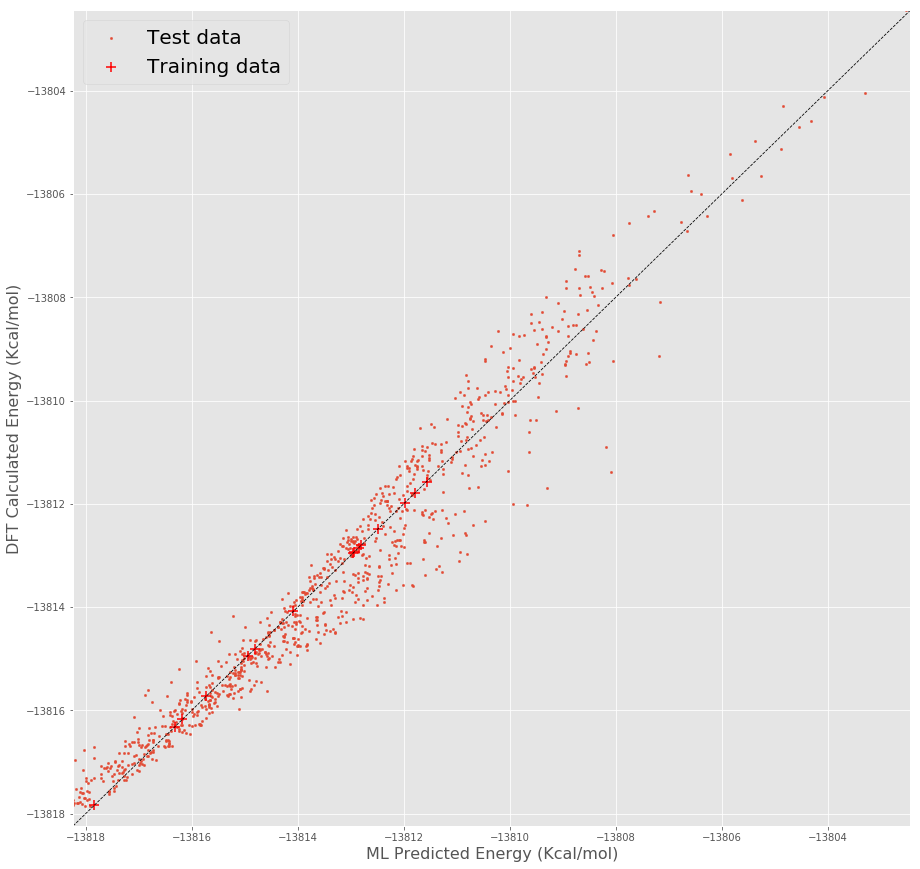

In [16]:
plt.figure(figsize = (15, 15))
plt.scatter(target_pred, testenergy, s = 5, marker = 'o', label='Test data')
print(len(trainingenergy))
print(len(target_pred_t))
plt.scatter(target_pred_t, trainingenergy, s = 100, marker = '+', c = 'r', label = 'Training data')
plt.plot(np.linspace(testenergy.min(), testenergy.max()), np.linspace(testenergy.min(), testenergy.max()), 'k--', linewidth = .8)
plt.legend(fontsize = 20)
plt.ylabel('DFT Calculated Energy (Kcal/mol)', fontsize = 16)
plt.xlabel('ML Predicted Energy (Kcal/mol)', fontsize = 16)
plt.xlim((testenergy.min(), testenergy.max()))
plt.ylim((testenergy.min(), testenergy.max()))
plt.savefig("parity_plot_50", dpi = 600)
plt.show()

In [17]:
for i in range(len(target_pred)):
    print (abs(target_pred[i] - testenergy[i]))
print(len(target_pred))

0.1536840993194346
0.0049566666912141955
0.9616992523369845
0.6872374611648411
0.48009017735785164
0.4246277666388778
0.5474268215202756
0.406941120774718
0.9775856414344162
0.37033873148720886
0.3059105517604621
0.19839903764113842
0.5552413556379179
0.34577992144113523
0.738480315058041
0.44044270393351326
0.36787766800443933
0.31482534796850814
0.04499187659530435
0.1686745548122417
0.2613678545130824
0.01980886555975303
1.8841186014506093
0.28191208394673595
0.24866171356006816
0.7334862558327586
0.34756029518939613
0.3128993960981461
0.17658153997945192
0.1948380831454415
0.09732340772461612
1.0356321407780342
0.6521292620018357
0.8989651740830595
0.48458512563411205
0.7728259245377558
0.07909261865279404
0.4571671157118544
0.5801076195311907
0.02000972213500063
0.37921231344625994
0.2231072397735261
0.1474518727281975
0.1970746632632654
0.5296246835496277
0.7423084870060848
0.11899667579564266
0.6326740362474084
0.2161640787653596
0.16722795321584272
1.7137721607832646
0.46947404

In [18]:
[np.array(testenergy).min(), np.array(testenergy).min()],[np.array(testenergy).max(), np.array(testenergy).max()]

([-13818.2374376709, -13818.2374376709],
 [-13802.43981380745, -13802.43981380745])

In [19]:
cluster_dict = {i: np.where(model.labels_ == i)[0] for i in range(model.n_clusters)}
cluster_1_index = cluster_dict[0]
cluster_2_index = cluster_dict[1]
cluster_3_index = cluster_dict[2]
cluster_4_index = cluster_dict[3]
cluster_5_index = cluster_dict[4]
cluster_6_index = cluster_dict[5]
cluster_7_index = cluster_dict[6]
cluster_8_index = cluster_dict[7]
cluster_9_index = cluster_dict[8]
cluster_10_index = cluster_dict[9]
cluster_11_index = cluster_dict[10]
cluster_12_index = cluster_dict[11]
cluster_13_index = cluster_dict[12]
cluster_14_index = cluster_dict[13]
cluster_15_index = cluster_dict[14]
cluster_16_index = cluster_dict[15]
cluster_17_index = cluster_dict[16]
cluster_18_index = cluster_dict[17]
cluster_19_index = cluster_dict[18]
cluster_20_index = cluster_dict[19]


cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []
cluster10 = []
cluster11 = []
cluster12 = []
cluster13 = []
cluster14 = []
cluster15 = []
cluster16 = []
cluster17 = []
cluster18 = []
cluster19 = []
cluster20 = []

for i in range(len(dataset)):
    for j in cluster_1_index:
        if j == i:
            cluster1.append(dataset[i])
    for k in cluster_2_index:
        if k == i:
            cluster2.append(dataset[i])
    for k in cluster_3_index:
        if k == i:
            cluster3.append(dataset[i])
    for j in cluster_4_index:
        if j == i:
            cluster4.append(dataset[i])
    for k in cluster_5_index:
        if k == i:
            cluster5.append(dataset[i])
    for k in cluster_6_index:
        if k == i:
            cluster6.append(dataset[i])
    for j in cluster_7_index:
        if j == i:
            cluster7.append(dataset[i])
    for k in cluster_8_index:
        if k == i:
            cluster8.append(dataset[i])
    for k in cluster_9_index:
        if k == i:
            cluster9.append(dataset[i])
    for j in cluster_10_index:
        if j == i:
            cluster10.append(dataset[i])
    for k in cluster_11_index:
        if k == i:
            cluster11.append(dataset[i])
    for k in cluster_12_index:
        if k == i:
            cluster12.append(dataset[i])
    for j in cluster_13_index:
        if j == i:
            cluster13.append(dataset[i])
    for k in cluster_14_index:
        if k == i:
            cluster14.append(dataset[i])
    for k in cluster_15_index:
        if k == i:
            cluster15.append(dataset[i])
    for j in cluster_16_index:
        if j == i:
            cluster16.append(dataset[i])
    for k in cluster_17_index:
        if k == i:
            cluster17.append(dataset[i])
    for k in cluster_18_index:
        if k == i:
            cluster18.append(dataset[i])
    for j in cluster_19_index:
        if j == i:
            cluster19.append(dataset[i])
    for k in cluster_20_index:
        if k == i:
            cluster20.append(dataset[i])

KeyError: 15

In [ ]:
def ploterr(x_train, y_train, x_test, y_pred_test, y_pred_all, sigma):
    fig = plt.figure(figsize = (15, 10))
    plt.plot(x_train, y_train, 'r.', markersize=10, label=u'Training Data')
    plt.plot(x_test, y_pred_test, 'b-', label=u'Predictions')
    plt.fill(np.concatenate([angle, angle[::-1]]),
             np.concatenate([y_pred_all - 1.9600 * sigma,
                             (y_pred_all + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')

    plt.rcParams.update({'font.size': 22})
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.legend(loc='upper left')

    plt.show()

In [ ]:
target_pred_all, std = gp.predict(np.array(dataset), return_std = True)

In [ ]:
ploterr(training, trainingenergy, test, target_pred, target_pred_all, std)

for i in dataset:
        if np.allclose(i[0], dataset[0][0], atol = 1e-4):
            print(i)
print(dataset[0])

In [ ]:
c = 0
sumofdeltas = []
clusteren = []
for i in cluster1:
    c = 0
    for j in range(len(i)):
        if j == 0 or j == 1:
            c+= (i[j]-.97)
        else:
            c+= (i[j] - 1.81863308058)
    sumofdeltas.append(c)
for i in cluster_1_index:
    clusteren.append(energy[i])
print(sumofdeltas)
print(clusteren)

In [ ]:
sumofdeltas = np.array(sumofdeltas)
clusteren = np.array(clusteren)
arrinds = sumofdeltas.argsort()
sumofdeltas_s = sumofdeltas[arrinds[::-1]]
clusteren_s = clusteren[arrinds[::-1]]
plt.plot(sumofdeltas_s, clusteren_s)
plt.show()

In [20]:
from mpl_toolkits.mplot3d import Axes3D

In [21]:
to_plot = np.array(dataset).T
cluster_1 = np.array(cluster1).T
cluster_2 = np.array(cluster2).T
cluster_3 = np.array(cluster3).T
cluster_4 = np.array(cluster4).T
cluster_5 = np.array(cluster5).T
cluster_6 = np.array(cluster6).T
cluster_7 = np.array(cluster7).T
cluster_8 = np.array(cluster8).T
cluster_9 = np.array(cluster9).T
cluster_10 = np.array(cluster10).T
cluster_11 = np.array(cluster11).T
cluster_12 = np.array(cluster12).T
cluster_13 = np.array(cluster13).T
cluster_14 = np.array(cluster14).T
cluster_15 = np.array(cluster15).T
cluster_16 = np.array(cluster16).T
cluster_17 = np.array(cluster17).T
cluster_18 = np.array(cluster18).T
cluster_19 = np.array(cluster19).T
cluster_20 = np.array(cluster20).T

to_plot.shape
print(to_plot[0,:].shape)

NameError: name 'cluster1' is not defined

NameError: name 'cluster_1' is not defined

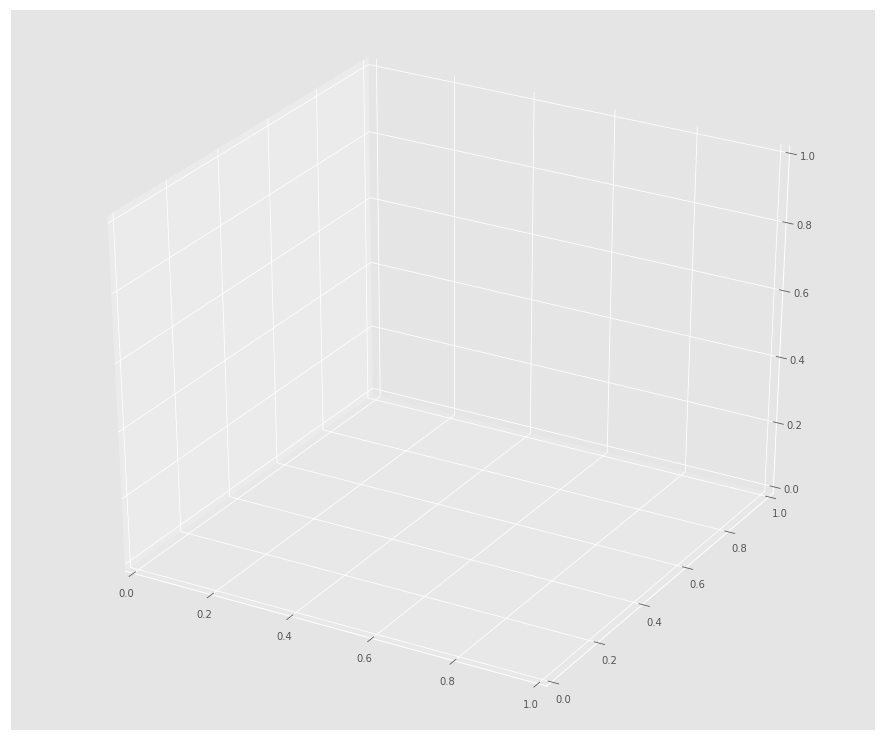

In [22]:

fig = plt.figure(figsize = (12, 10))
ax = Axes3D(fig)
ax.scatter(cluster_1[0, :], cluster_1[1, :], cluster_1[2, :])
ax.scatter(cluster_2[0, :], cluster_2[1, :], cluster_2[2, :])
ax.scatter(cluster_3[0, :], cluster_3[1, :], cluster_3[2, :])
ax.scatter(cluster_4[0, :], cluster_4[1, :], cluster_4[2, :])
ax.scatter(cluster_5[0, :], cluster_5[1, :], cluster_5[2, :])
ax.scatter(cluster_6[0, :], cluster_6[1, :], cluster_6[2, :])
ax.scatter(cluster_7[0, :], cluster_7[1, :], cluster_7[2, :])
ax.scatter(cluster_8[0, :], cluster_8[1, :], cluster_8[2, :])
ax.scatter(cluster_9[0, :], cluster_9[1, :], cluster_9[2, :])
ax.scatter(cluster_10[0, :], cluster_10[1, :], cluster_10[2, :])
ax.scatter(cluster_11[0, :], cluster_11[1, :], cluster_11[2, :])
ax.scatter(cluster_12[0, :], cluster_12[1, :], cluster_12[2, :])
ax.scatter(cluster_13[0, :], cluster_13[1, :], cluster_13[2, :])
ax.scatter(cluster_14[0, :], cluster_14[1, :], cluster_14[2, :])
ax.scatter(cluster_15[0, :], cluster_15[1, :], cluster_15[2, :])
ax.scatter(cluster_16[0, :], cluster_16[1, :], cluster_16[2, :])
ax.scatter(cluster_17[0, :], cluster_17[1, :], cluster_17[2, :])
ax.scatter(cluster_18[0, :], cluster_18[1, :], cluster_18[2, :])
ax.scatter(cluster_19[0, :], cluster_19[1, :], cluster_19[2, :])
ax.scatter(cluster_20[0, :], cluster_20[1, :], cluster_20[2, :])

ax.view_init()
ax.set_zlabel('Bond Angle (Rad)', fontsize = 16)
plt.xlabel('Bond 1 Length (Å)', fontsize = 16)
plt.ylabel('Bond 2 Length (Å)', fontsize = 16)
plt.savefig("plot_of_6_clusters", dpi = 600)
plt.show()

In [23]:
# Neural Network

In [24]:
def neural_network_flex(x, W_0, W_1, W_2, b_0, b_1, b_2, layers = 1):
 # this is based on the tensorflow schema
    
    if layers == 1: 
        h = tf.tanh(tf.matmul(x, W_0) + b_0)
        h = tf.matmul(h, W_1) + b_1
    if layers == 2: 
        h = tf.tanh(tf.matmul(x, W_0) + b_0)
        h = tf.tanh(tf.matmul(h, W_1) + b_1)
        h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])


In [25]:
N = 15
D = 3

In [26]:
x = training
print(x.shape)

(15, 3)


In [32]:
hidden1 = 10
hidden2 = 15
W_0 = Normal(loc=tf.zeros([D, hidden1], dtype = np.float64), scale=tf.ones([D, hidden1], dtype = np.float64))
W_1 = Normal(loc=tf.zeros([hidden1, hidden2], dtype = np.float64), scale=tf.ones([hidden1, hidden2], dtype = np.float64))
W_2 = Normal(loc=tf.zeros([hidden2, 1], dtype = np.float64), scale=tf.ones([hidden2, 1], dtype = np.float64))
b_0 = Normal(loc=tf.zeros((hidden1), dtype = np.float64), scale=tf.ones((hidden1), dtype = np.float64))
b_1 = Normal(loc=tf.zeros((hidden2), dtype = np.float64), scale=tf.ones((hidden2), dtype = np.float64))
b_2 = Normal(loc=tf.zeros((1), dtype = np.float64), scale=tf.ones((1), dtype = np.float64))

x = training
y = Normal(loc=neural_network_flex(x, W_0, W_1, W_2, b_0, b_1, b_2, layers = 2),
           scale=0.1 * tf.ones(N, dtype = np.float64))

(15, 3)


In [28]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, hidden1], dtype = np.float64),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, hidden1], dtype = np.float64)))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [hidden1, hidden2], dtype = np.float64),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [hidden1, hidden2], dtype = np.float64)))
qW_2 = Normal(loc=tf.get_variable("qW_2/loc", [hidden2, 1], dtype = np.float64),
              scale=tf.nn.softplus(tf.get_variable("qW_2/scale", [hidden2, 1], dtype = np.float64)))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [hidden1], dtype = np.float64),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [hidden1], dtype = np.float64)))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [hidden2], dtype = np.float64),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [hidden2], dtype = np.float64)))
qb_2 = Normal(loc=tf.get_variable("qb_2/loc", [1], dtype = np.float64),
              scale=tf.nn.softplus(tf.get_variable("qb_2/scale", [1], dtype = np.float64)))

In [33]:
rs = np.random.RandomState(0)


mus = tf.stack(
    [neural_network_flex(x, qW_0.sample(), qW_1.sample(), qW_2.sample, qb_0.sample(), qb_1.sample(), qb_2.sample)
     for _ in range(10)])

# References
1. 